# Logistic regression modeling and interpretation using Yelp reviews

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels import graphics
from patsy import dmatrices


plt.rcParams['figure.figsize'] = [15, 10]

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read data

In [2]:
reviews = pd.read_csv('data/reviews.csv')

# Balance the data

In [3]:
n_not_recomended = (reviews['regular'] == 0).sum()
reg_reviews = reviews[reviews['regular'] == 1].sample(n=n_not_recomended, random_state=1)
not_reviews = reviews[reviews['regular'] == 0].sample(n=n_not_recomended, random_state=1)

# TODO do we need to suffle
balanced_reviews = reg_reviews.append(not_reviews).sample(frac=1., random_state=0).reset_index()
len(balanced_reviews), len(reviews)

(54114, 252508)

# Interaction features

In [4]:
del balanced_reviews['index']
log_columns = ['friends', 'numSentence', 'numWords', 'photos', 'reviews', 'totSentiment']
for column in log_columns:
    balanced_reviews[column+'_log'] = np.log(1+balanced_reviews[column])

balanced_reviews['friends_photos'] = np.log(balanced_reviews['photos']+1) * np.log(balanced_reviews['friends']+1)
balanced_reviews['extream_avgSentiment'] = np.log(balanced_reviews['extream']+1) * np.log(balanced_reviews['avgSentiment']+1)
balanced_reviews['photos_2'] = balanced_reviews['photos']**2
balanced_reviews['friends_2'] = balanced_reviews['friends']**2
balanced_reviews = balanced_reviews.drop(columns=log_columns)

# Cook's distance

In [ ]:
features = balanced_reviews.columns.tolist()
features.remove('regular')
features = '+'.join(features)
model = smf.ols("regular ~ %s" % features, balanced_reviews).fit()

influence = model.get_influence()
influence_summary = influence.summary_frame()
influence_summary.head()

# Plot Cook's distance

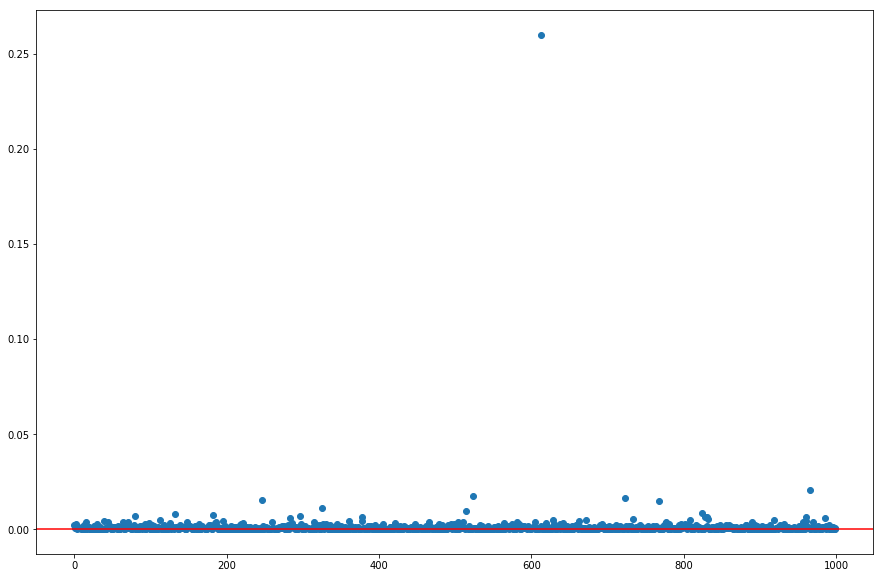

In [96]:
plt.plot(influence_summary.index, influence_summary['cooks_d'], 'o')
plt.axhline(y=4/(len(balanced_reviews)-1), color='r', linestyle='-')

# Filter outliers

In [97]:
balanced_reviews = balanced_reviews[influence_summary['cooks_d'] < 0.02]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

# Scale data

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

regular = balanced_reviews['regular']

del balanced_reviews['regular']
columns = balanced_reviews.columns
balanced_reviews = scaler.fit_transform(balanced_reviews)
balanced_reviews = pd.DataFrame(balanced_reviews, columns=columns)

balanced_reviews['regular'] = regular

# Linear regression

In [11]:
features = balanced_reviews.columns.tolist()
features.remove('regular')
features = '+'.join(features)
model = smf.ols("regular ~ %s" % features, balanced_reviews).fit()

print(model.params)
model.summary2()

Intercept              -1.085210
avgSentiment           -0.991372
has_photo               0.022407
rating                 -0.049076
extream                -0.147214
n_reviews               0.008860
rating_restaurant       0.325389
regularRatio            0.975883
friends_log             0.367823
numSentence_log        -2.808056
numWords_log            0.954730
photos_log              0.844682
reviews_log             0.955614
totSentiment_log        2.665941
friends_photos         -1.517207
extream_avgSentiment    0.252730
photos_2                0.168947
friends_2              -0.061484
dtype: float64


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS              Adj. R-squared:     0.426     
Dependent Variable:   regular          AIC:                48527.0044
Date:                 2018-05-04 16:26 BIC:                48687.1836
No. Observations:     54114            Log-Likelihood:     -24246.   
Df Model:             17               F-statistic:        2364.     
Df Residuals:         54096            Prob (F-statistic): 0.00      
R-squared:            0.426            Scale:              0.14350   
---------------------------------------------------------------------
                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept            -1.0852   0.0284 -38.2709 0.0000 -1.1408 -1.0296
avgSentiment         -0.9914   0.0418 -23.7000 0.0000 -1.0734 -0.9094
has_photo             0.0224   0.0042   5.3419 0.0000  0.0142  0.0306
rating               -0.0491   0.0074  -6.6020 0.0000 -0.0636 -0.0345
extream              -0.1472   0.0189  -7.8070 0.0000 -0.1842 -0.1103
n_reviews             0.0089   0.0066   1.3463 0.1782 -0.0040  0.0218
rating_restaurant     0.3254   0.0246  13.2323 0.0000  0.2772  0.3736
regularRatio          0.9759   0.0172  56.8844 0.0000  0.9423  1.0095
friends_log           0.3678   0.0099  37.1477 0.0000  0.3484  0.3872
numSentence_log      -2.8081   0.1280 -21.9378 0.0000 -3.0589 -2.5572
numWords_log          0.9547   0.0245  38.9537 0.0000  0.9067  1.0028
photos_log            0.8447   0.0254  33.3097 0.0000  0.7950  0.8944
reviews_log           0.9556   0.0146  65.5540 0.0000  0.9270  0.9842
totSentiment_log      2.6659   0.1272  20.9584 0.0000  2.4166  2.9153
friends_photos       -1.5172   0.0414 -36.6286 0.0000 -1.5984 -1.4360
extream_avgSentiment  0.2527   0.0270   9.3575 0.0000  0.1998  0.3057
photos_2              0.1689   0.2304   0.7332 0.4634 -0.2827  0.6206
friends_2            -0.0615   0.0550  -1.1178 0.2637 -0.1693  0.0463
---------------------------------------------------------------------
Omnibus:               1174.380       Durbin-Watson:          2.008  
Prob(Omnibus):         0.000          Jarque-Bera (JB):       774.707
Skew:                  0.169          Prob(JB):               0.000  
Kurtosis:              2.521          Condition No.:          329    
=====================================================================

"""

# Scale back example

In [60]:
scalled_value = .3
to_unscale = 'n_reviews'

row = balanced_reviews[columns].iloc[[1]] * 0.

row[to_unscale] = scalled_value
result = pd.DataFrame(scaler.inverse_transform(row), columns=columns)[to_unscale].iloc[0]
result

1447.8

# Scale value

In [78]:
origial_value = 4000
to_unscale = 'n_reviews'

row = balanced_reviews[columns].iloc[[1]] * 0.

row[to_unscale] = origial_value
result = pd.DataFrame(scaler.transform(row), columns=columns)[to_unscale].iloc[0]
result

0.8288437629506837

# Weights plot on scaled features

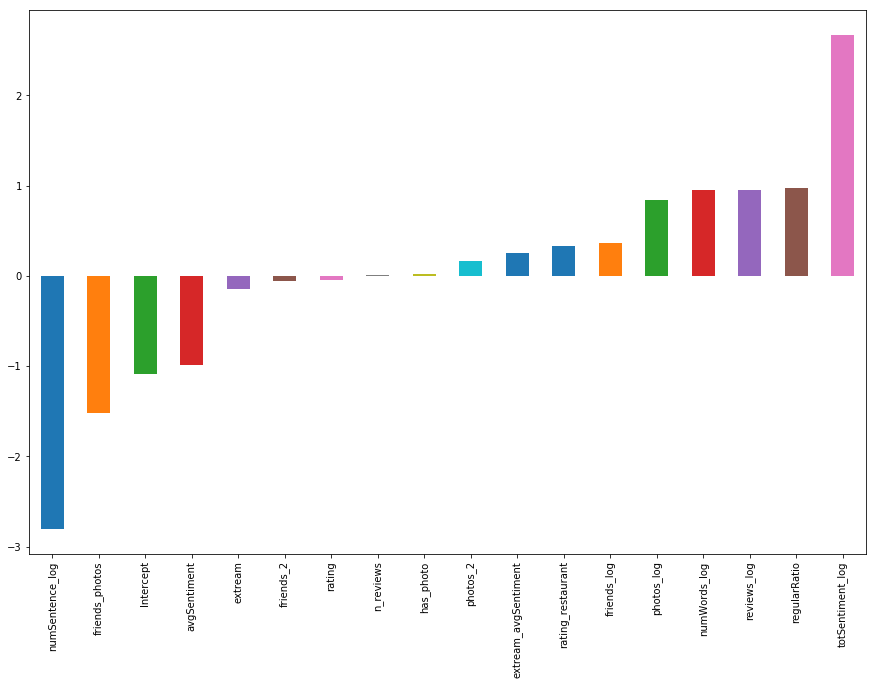

In [14]:
model.params.sort_values().plot(kind='bar');

# Correlation plot

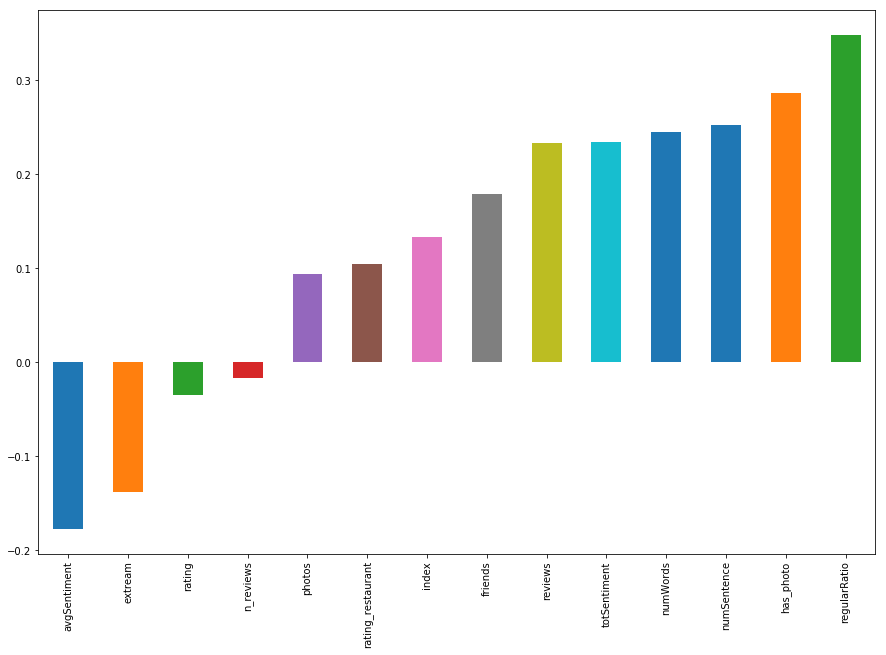

In [24]:
corrs = {}
for column in balanced_reviews.columns[~balanced_reviews.columns.isin([column])]:
    corrs[column] = balanced_reviews['regular'].corr(balanced_reviews[column])
pd.Series(corrs).sort_values().plot(kind='bar')

# Q-Q plot

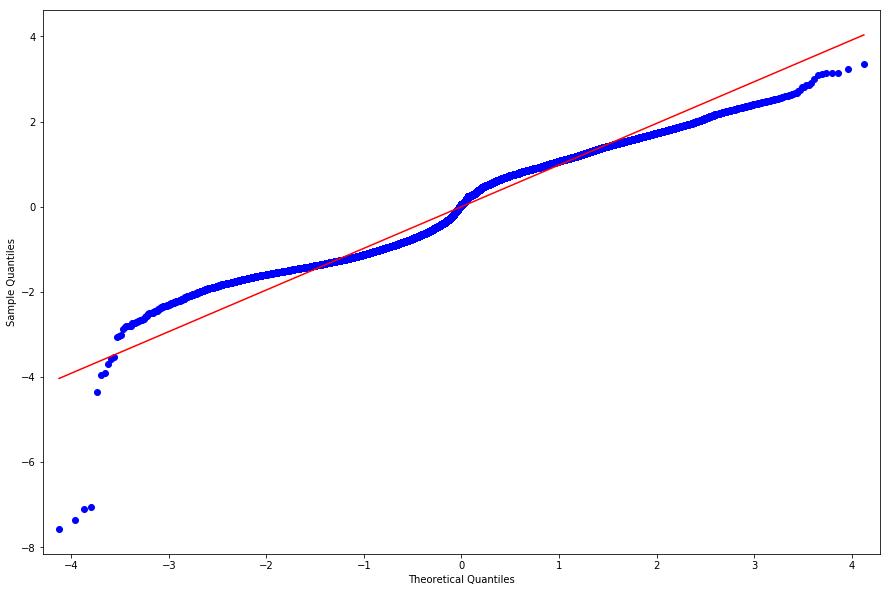

In [25]:
# residuals
residuals = model.resid
line = 'r' # '45' 's' 'q' 'r'
graphics.gofplots.qqplot(residuals, dist=stats.t, line=line, fit=True);

# Residual plot

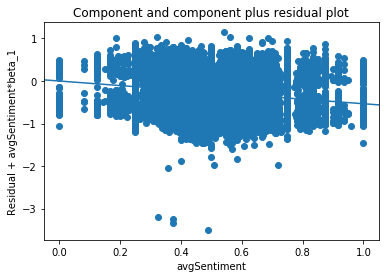

In [7]:
sm.graphics.plot_ccpr(model, exog_idx=1);

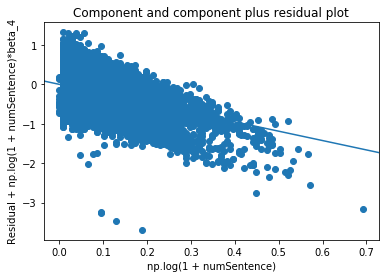

In [8]:
sm.graphics.plot_ccpr(model, exog_idx=4);

In [85]:
features = balanced_reviews.columns.tolist()
features.remove('regular')
features = '+'.join(features)
model = smf.ols("regular ~ %s" % features, balanced_reviews.iloc[:1000]).fit()

print(model.params)
model.summary2()

Intercept               -0.814050
avgSentiment            -0.977847
has_photo                0.063847
rating                  -0.090732
extream                 -0.179761
n_reviews               -0.013529
rating_restaurant        0.330634
regularRatio             0.841479
friends_log              0.296686
numSentence_log         -2.317048
numWords_log             0.671530
photos_log               0.566468
reviews_log              1.080595
totSentiment_log         2.297713
friends_photos          -1.131352
extream_avgSentiment     0.298872
photos_2                42.560503
friends_2               -1.572807
dtype: float64


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:                OLS               Adj. R-squared:      0.410    
Dependent Variable:   regular           AIC:                 942.4169 
Date:                 2018-05-04 16:57  BIC:                 1030.7565
No. Observations:     1000              Log-Likelihood:      -453.21  
Df Model:             17                F-statistic:         41.84    
Df Residuals:         982               Prob (F-statistic):  1.17e-103
R-squared:            0.420             Scale:               0.14759  
----------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025   0.975] 
----------------------------------------------------------------------
Intercept            -0.8141   0.2202 -3.6974 0.0002  -1.2461  -0.3820
avgSentiment         -0.9778   0.3157 -3.0975 0.0020  -1.5974  -0.3583
has_photo             0.0638   0.0313  2.0422 0.0414   0.0025   0.1252
rating               -0.0907   0.0551 -1.6471 0.0999  -0.1988   0.0174
extream              -0.1798   0.1390 -1.2937 0.1961  -0.4524   0.0929
n_reviews            -0.0135   0.0497 -0.2724 0.7854  -0.1110   0.0839
rating_restaurant     0.3306   0.1837  1.7999 0.0722  -0.0299   0.6911
regularRatio          0.8415   0.1287  6.5403 0.0000   0.5890   1.0940
friends_log           0.2967   0.0761  3.8971 0.0001   0.1473   0.4461
numSentence_log      -2.3170   0.9568 -2.4216 0.0156  -4.1947  -0.4394
numWords_log          0.6715   0.1807  3.7162 0.0002   0.3169   1.0261
photos_log            0.5665   0.2095  2.7039 0.0070   0.1553   0.9776
reviews_log           1.0806   0.1132  9.5457 0.0000   0.8584   1.3027
totSentiment_log      2.2977   0.9285  2.4747 0.0135   0.4757   4.1197
friends_photos       -1.1314   0.3577 -3.1628 0.0016  -1.8333  -0.4294
extream_avgSentiment  0.2989   0.1987  1.5039 0.1329  -0.0911   0.6889
photos_2             42.5605  47.1036  0.9036 0.3665 -49.8748 134.9958
friends_2            -1.5728   2.8156 -0.5586 0.5766  -7.0981   3.9525
----------------------------------------------------------------------
Omnibus:               21.719         Durbin-Watson:            2.092 
Prob(Omnibus):         0.000          Jarque-Bera (JB):         17.040
Skew:                  0.232          Prob(JB):                 0.000 
Kurtosis:              2.560          Condition No.:            9061  
======================================================================
* The condition number is large (9e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

# Influence plot

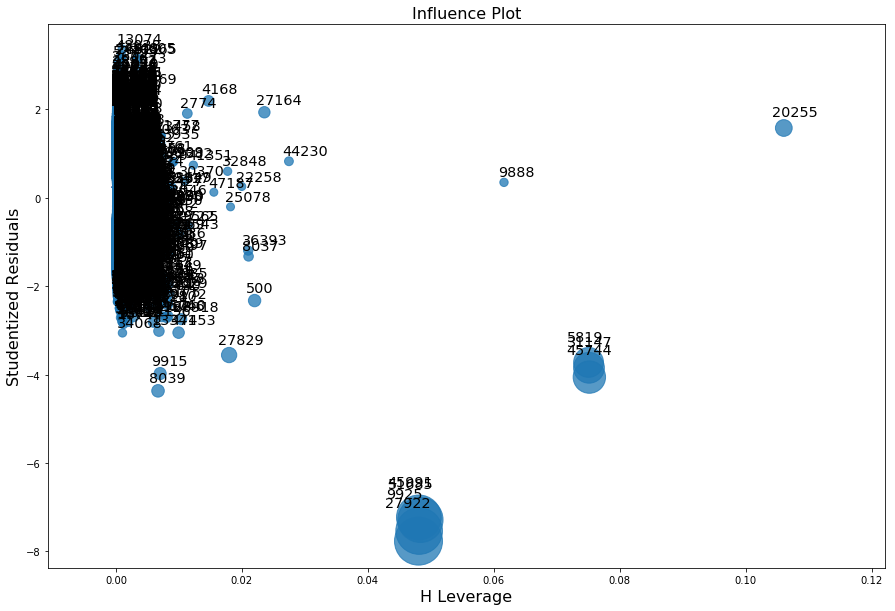

In [31]:
sm.graphics.influence_plot(model);